In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sktime.forecasting.fbprophet import Prophet
from sktime.forecasting.base import ForecastingHorizon
from sktime.utils.plotting import plot_series
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error

In [2]:
# flow data
daily_data = pd.read_csv('./training_dataset/daily_dataset.csv')
hourly_data = pd.read_csv('./training_dataset/hourly_dataset.csv')
fivemin_data = pd.read_csv('./training_dataset/per5min_dataset.csv')
# other data
weather_data = pd.read_csv('./training_dataset/weather.csv')
epidemic_data = pd.read_csv('./training_dataset/epidemic.csv')
# 筛选训练数据
daily_train = daily_data[daily_data['train or test']=='train']
hourly_train = hourly_data[hourly_data['train or test']=='train']
fivemin_train = fivemin_data[fivemin_data['train or test']=='train']
weather_train = weather_data[weather_data['train or test']=='train']
epidemic_data = epidemic_data[epidemic_data['train or test']=='train']
hourly_train_new = hourly_train.copy()
hourly_train_new['day'] = hourly_train_new['time'].apply(lambda x:x[0:10])
cols = list(hourly_train_new.columns)[1:-2]
for each_col in cols:
    hourly_train_new[each_col] = hourly_train_new[each_col].apply(lambda x:abs(x))

In [7]:
submission = pd.read_csv('sample_submission.csv')

In [3]:
# # 去除抄表异常值
# def anomaly_detect(x, threshold):
#     if x>threshold:
#         return None
#     else:
#         return x

# flow_threshold = [200, 60, 200, 120, 15, 500, 50, 10, 25, 50, 20, 100, 10, 12, 10, 20, 30, 150, 50, 8]
# for i in range(len(cols)):
#     threshold_i = flow_threshold[i]
#     hourly_train_new[cols[i]] = hourly_train_new[cols[i]].apply(lambda x:anomaly_detect(x, threshold_i))
# hourly_train_new = hourly_train_new.fillna(method='ffill')

In [4]:
hourly_train_new['datetime'] = hourly_train_new['time'].apply(lambda x:pd.Timestamp(x))

## 每个flow单独分析、处理和建模

### flow_1

In [19]:
# flow_1 
import datetime
flow_one = hourly_train_new[['datetime', 'flow_1']].copy()
flow_one['flow_1'] = flow_one['flow_1'].apply(lambda x:x if x<500 else None)
flow_one.index = flow_one['datetime']
flow_one_all = flow_one['flow_1'].copy()
for each_index in flow_one_all[flow_one_all.isnull()].index:
    index_before = each_index-datetime.timedelta(days=3, minutes=0, seconds=0)
    index_after = each_index+datetime.timedelta(days=4, minutes=0, seconds=0)
    value_before = flow_one_all[index_before]
    flow_one_all[each_index] = value_before

18:15:37 - cmdstanpy - INFO - Chain [1] start processing
18:15:38 - cmdstanpy - INFO - Chain [1] done processing


0.19593649285175493

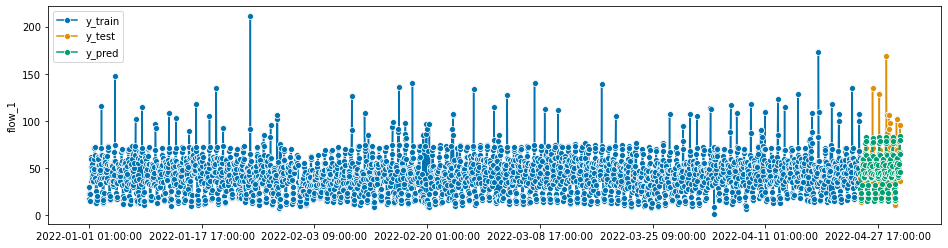

In [23]:
# Prophet
# 分段预测
end_date = pd.Timestamp('2022-04-25 00:00:00')
test_begin = pd.Timestamp('2022-04-25 00:00:00')
test_end = pd.Timestamp('2022-05-01 01:00:00')
flow_one_train = flow_one_all[:end_date]
test_index_one = pd.date_range(start='2022-04-25',end='2022-05-01',freq='H')
flow_one_test = pd.Series(index=test_index_one, dtype='float64')
fh = ForecastingHorizon(flow_one_test.index, is_relative=False)
y_test = flow_one_all[test_begin:test_end]
forecaster = Prophet(
    seasonality_mode="additive",
    n_changepoints=int(len(flow_one_train) / 24),
    weekly_seasonality=True,
    daily_seasonality=True
)

forecaster.fit(flow_one_train)
y_pred = forecaster.predict(fh)
y_pred

plot_series(flow_one_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
mean_absolute_percentage_error(y_test, y_pred, symmetric=False)

In [8]:
test_index = pd.date_range(start='2022-05-01',end='2022-05-08',freq='H')
flow_one_test = pd.Series(index=test_index, dtype='float64')
fh = ForecastingHorizon(flow_one_test.index, is_relative=False)

In [10]:
forecaster = Prophet(
    seasonality_mode="additive",
    n_changepoints=int(len(flow_one_train) / 7),
    weekly_seasonality=True,
    daily_seasonality=True
)

forecaster.fit(flow_one_train)
y_pred = forecaster.predict(fh)
y_pred
y_pred.index = flow_one_test.index

# plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
# mean_absolute_percentage_error(y_test, y_pred, symmetric=False)

18:07:02 - cmdstanpy - INFO - Chain [1] start processing
18:07:07 - cmdstanpy - INFO - Chain [1] done processing


2022-05-01 00:00:00    38.931501
2022-05-01 01:00:00    22.821602
2022-05-01 02:00:00    13.204590
2022-05-01 03:00:00    10.523243
2022-05-01 04:00:00    12.878541
                         ...    
2022-05-07 20:00:00    68.770803
2022-05-07 21:00:00    74.557821
2022-05-07 22:00:00    70.305934
2022-05-07 23:00:00    56.438524
2022-05-08 00:00:00    38.123603
Length: 169, dtype: float64

flow_1


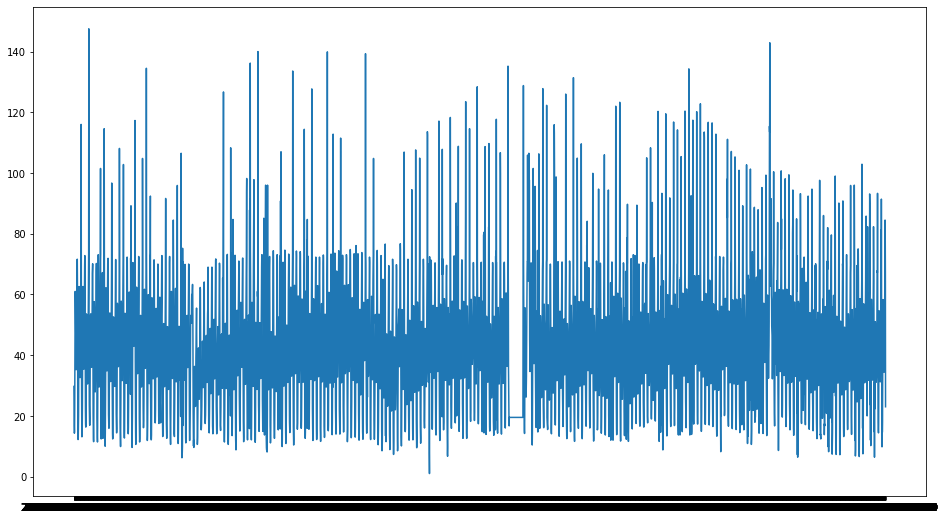

flow_2


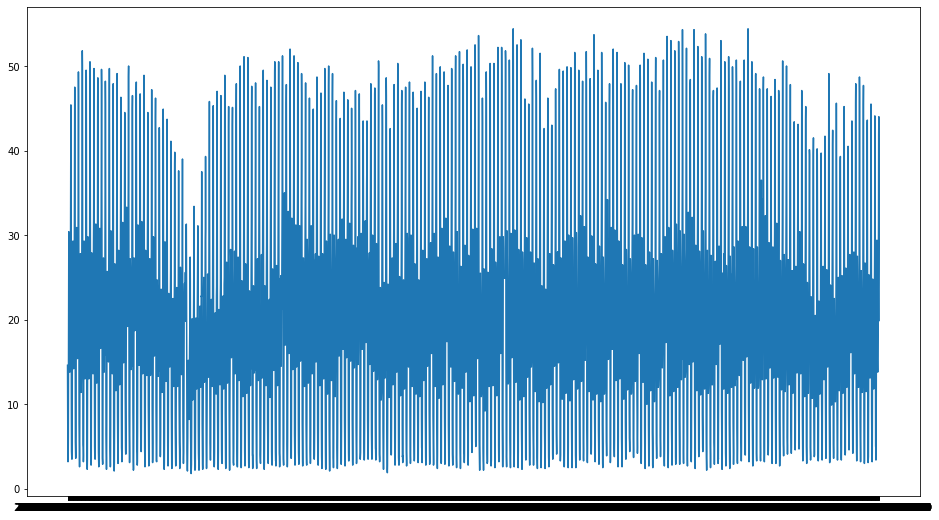

flow_3


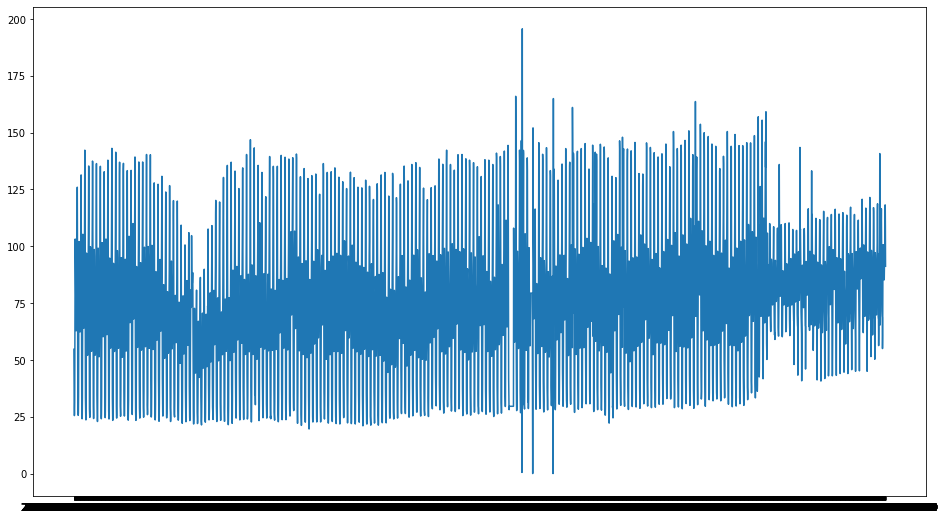

flow_4


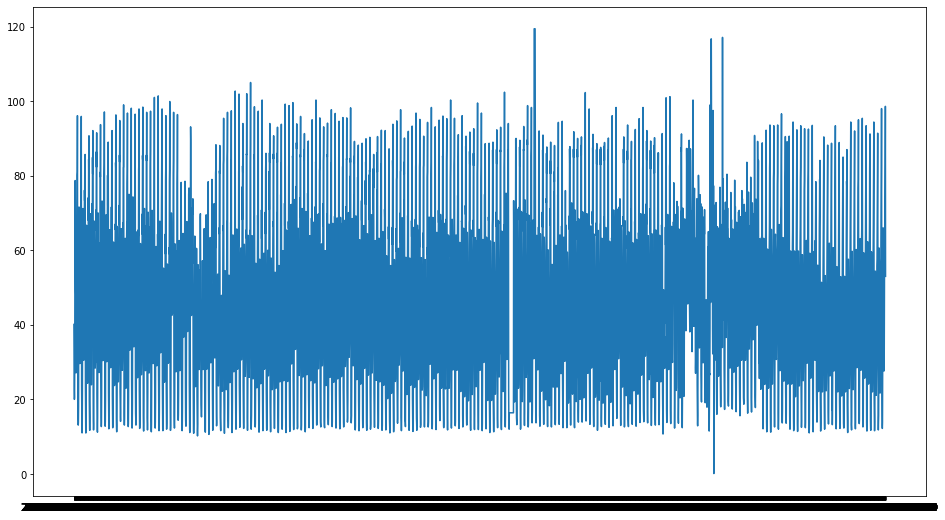

flow_5


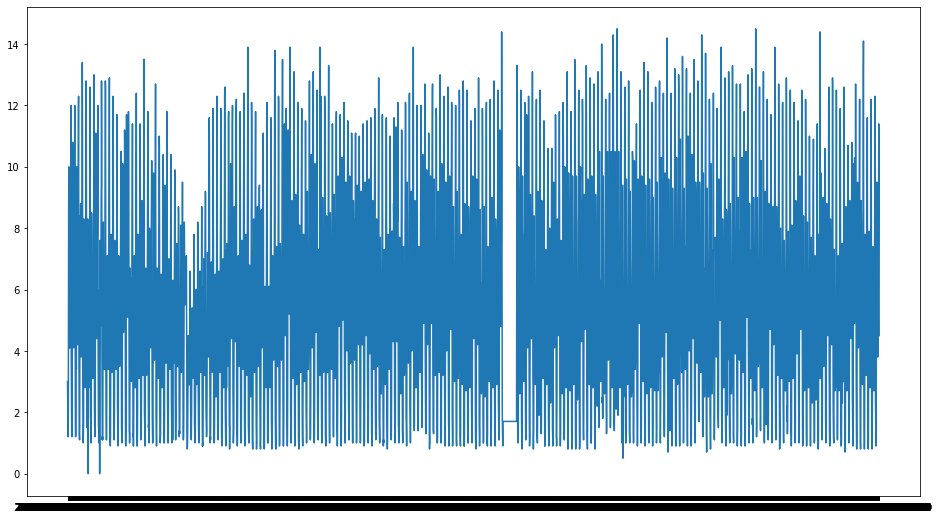

flow_6


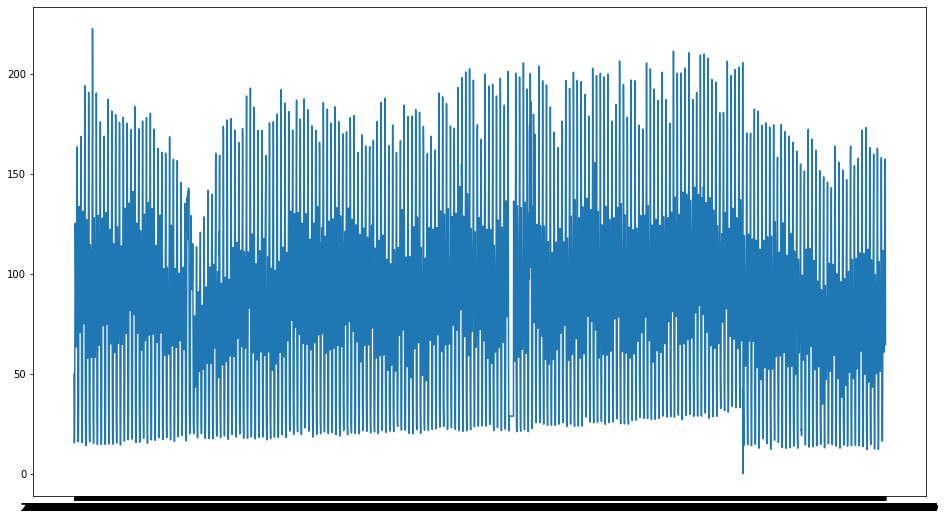

flow_7


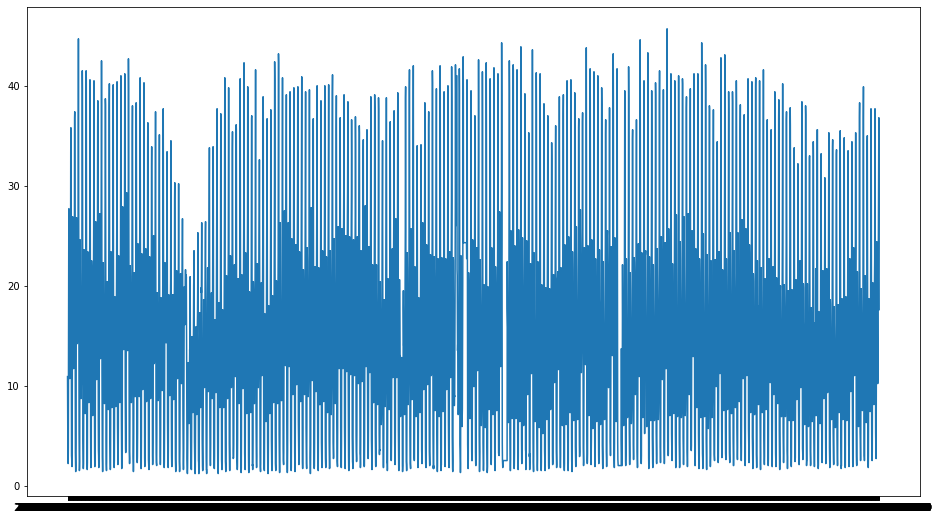

flow_8


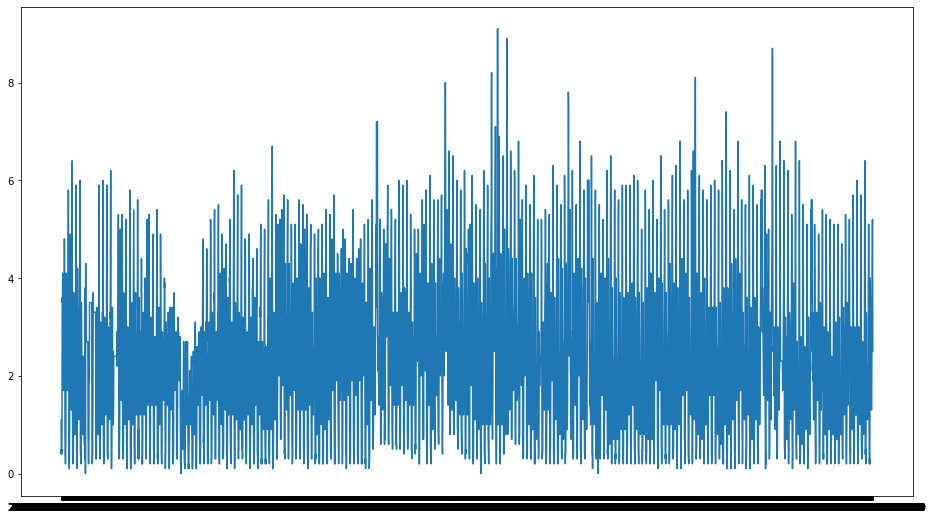

flow_9


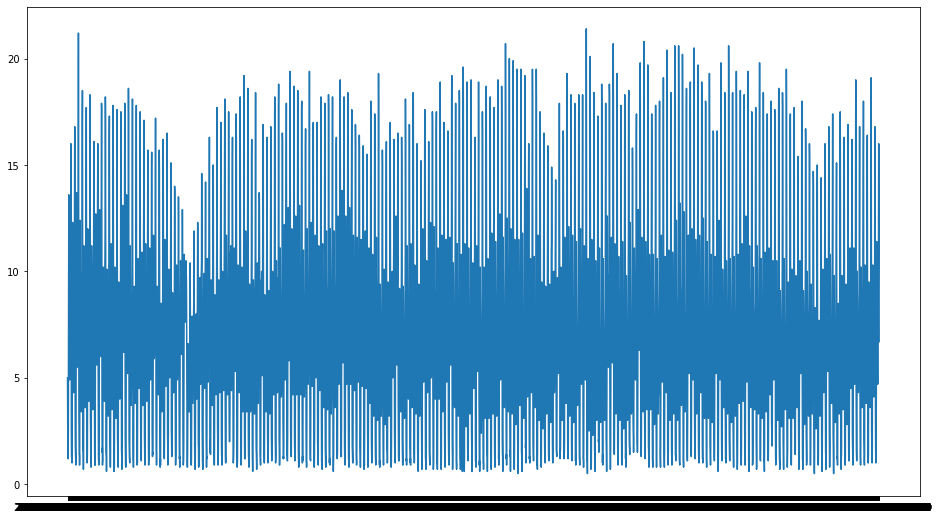

flow_10


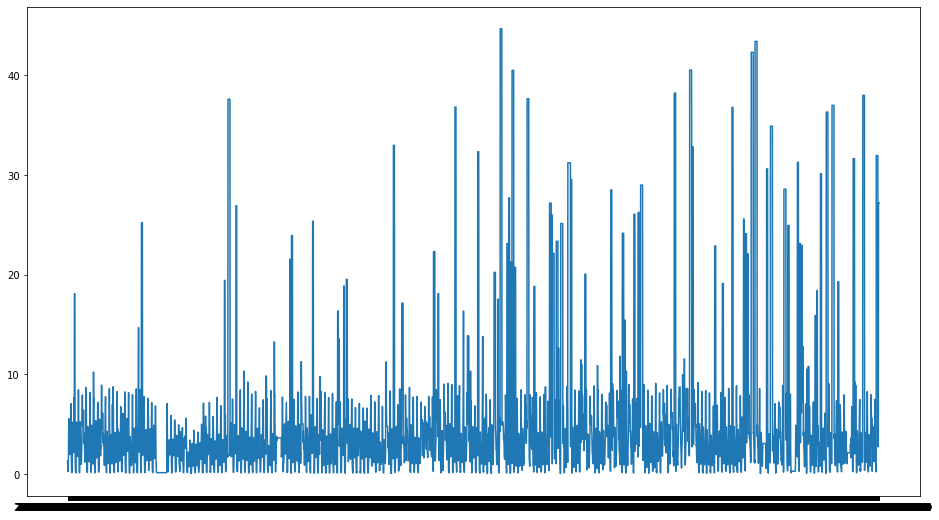

flow_11


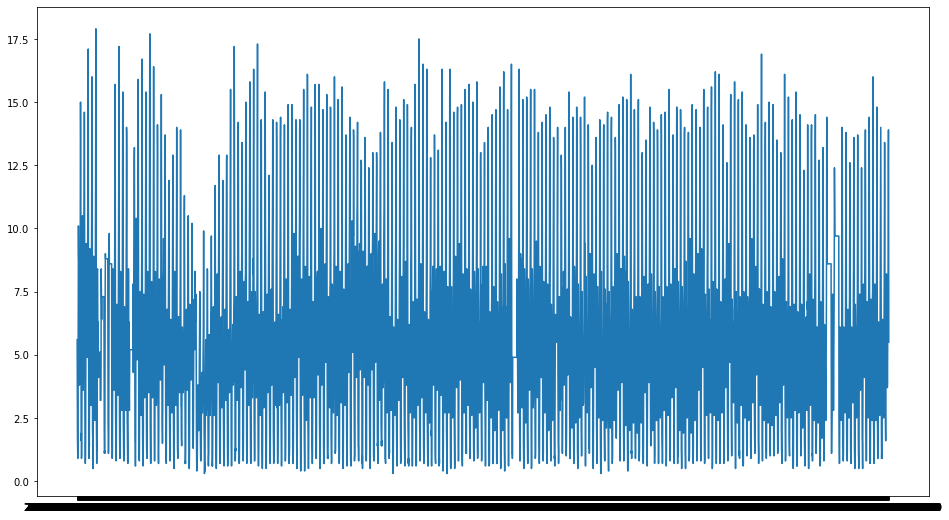

flow_12


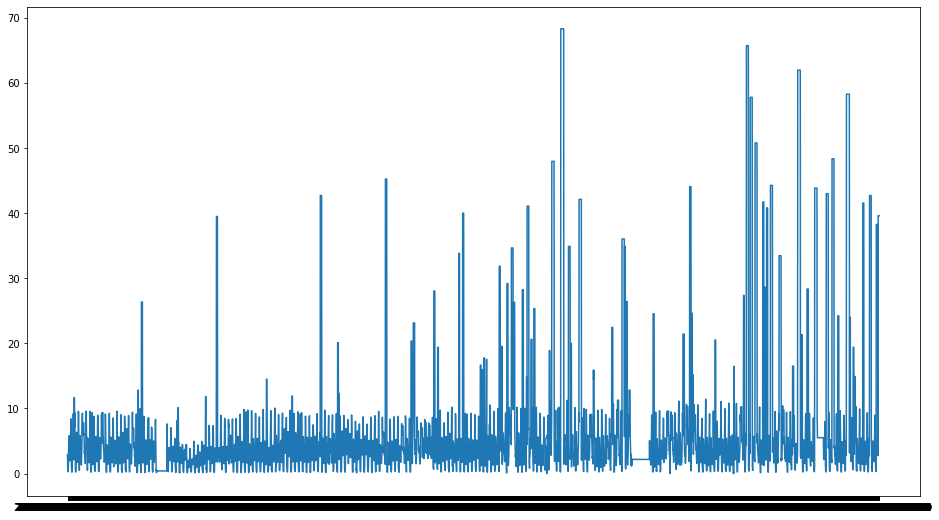

flow_13


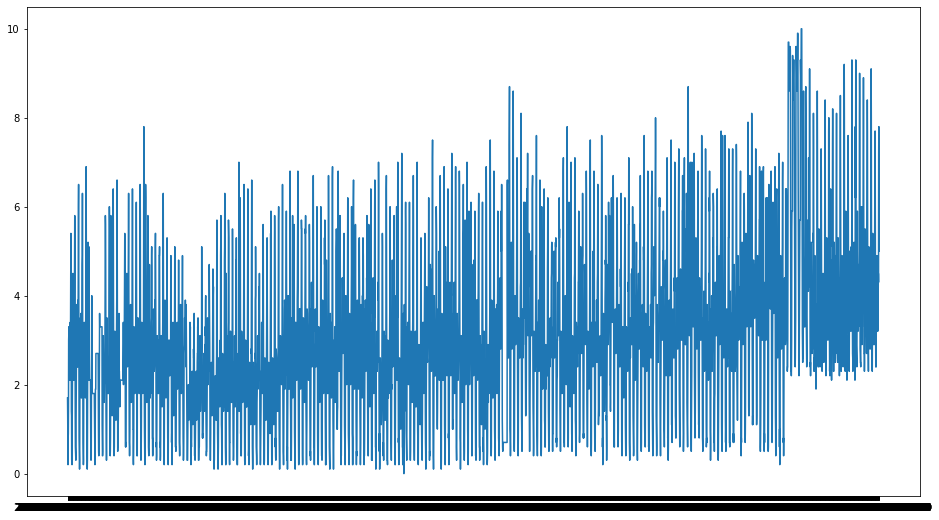

flow_14


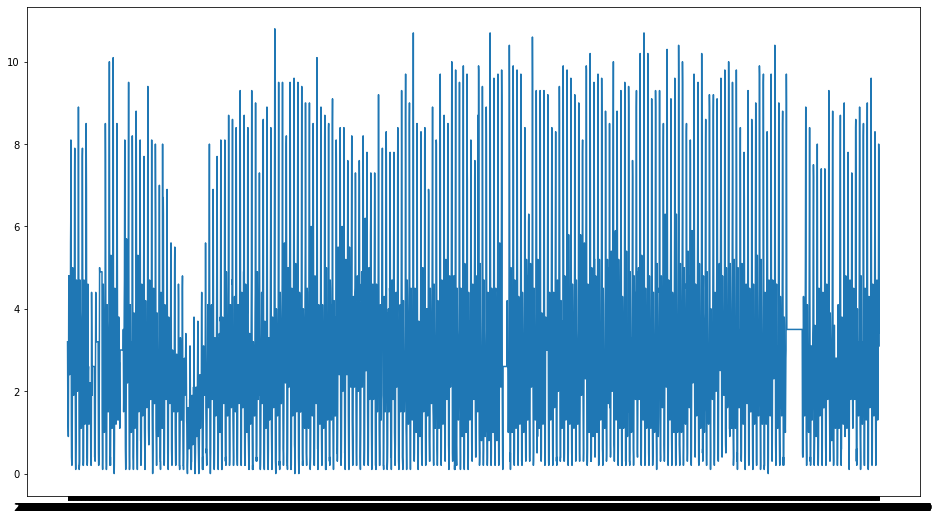

flow_15


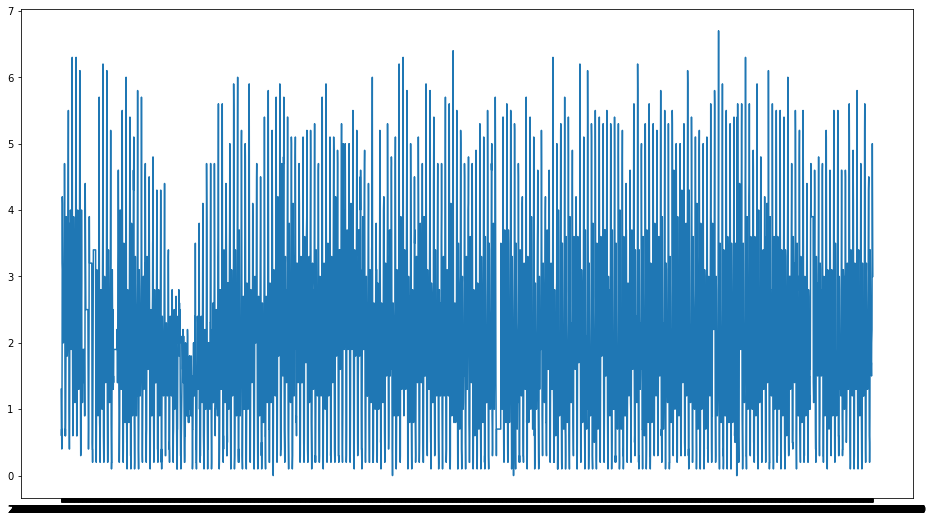

flow_16


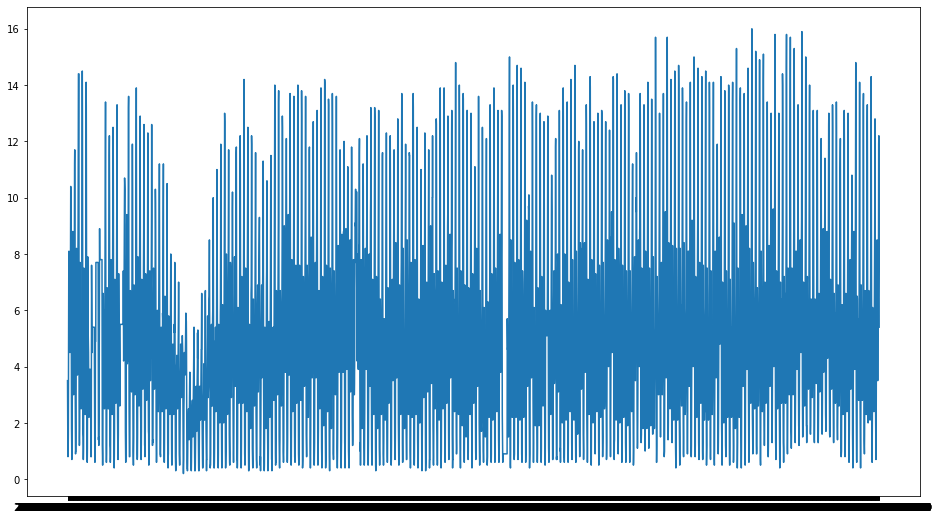

flow_17


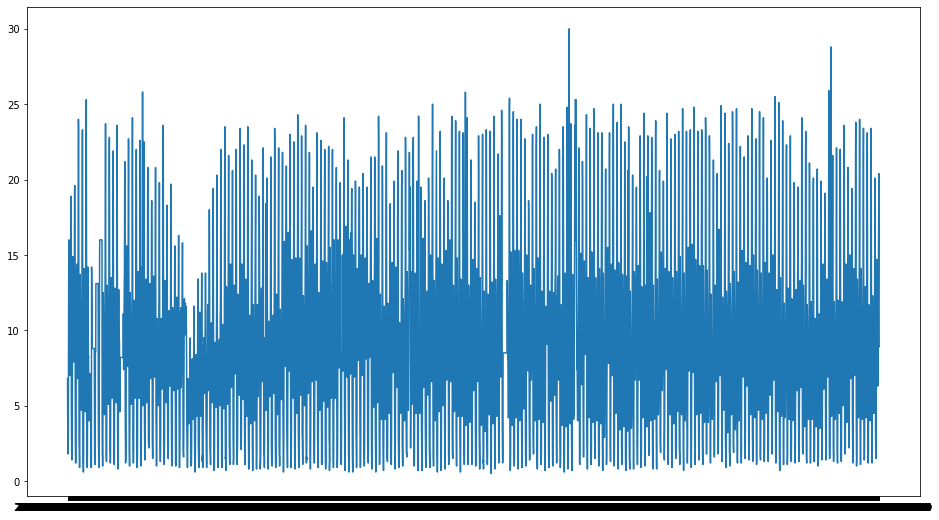

flow_18


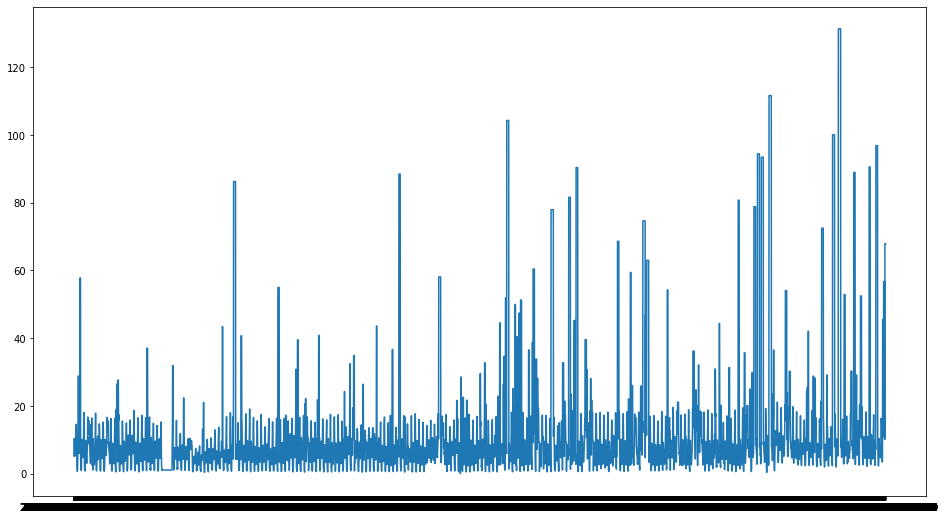

flow_19


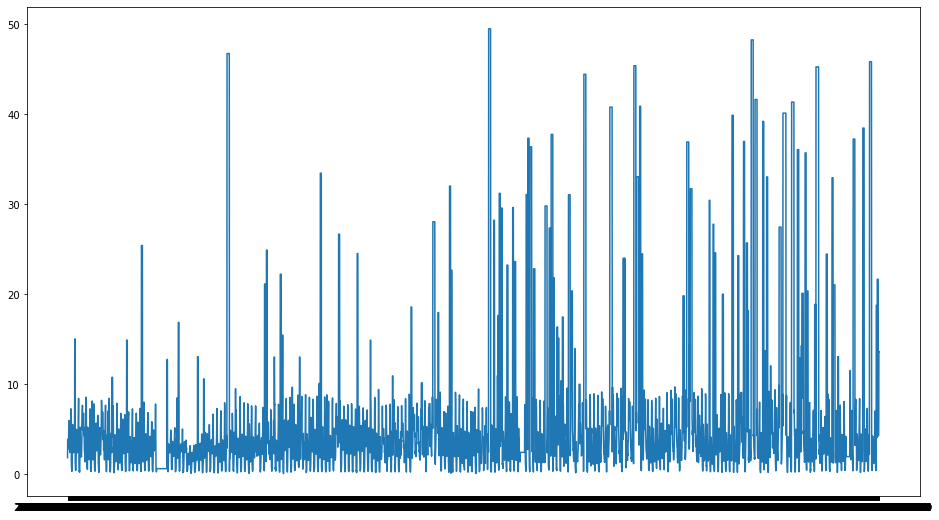

flow_20


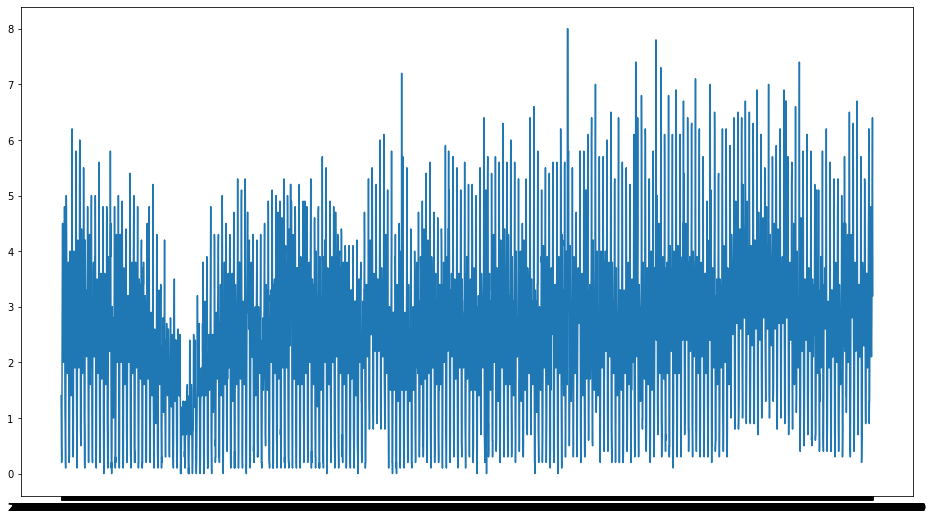

In [8]:
# plot
for each_col in cols:
    print(each_col)
    fig = plt.figure(figsize=(16,9))
    plt.plot(list(hourly_train_new['time']),list(hourly_train_new[each_col]))
    plt.show()